In [1]:
from google.colab import drive
drive.mount("/content/drive")
# @title Mount Drive

Mounted at /content/drive


In [1]:
%%capture

import os 
import requests

dest_folder = '/content/drive/MyDrive/reproduce_Momi_et_al_2022/'
if not os.path.exists(dest_folder):
  os.makedirs(dest_folder)  # create folder if it does not exist

os.chdir(dest_folder)

#!gdown url
os.chdir(dest_folder)
!gdown --folder 'https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF' --remaining-ok # for folders

# @title download data


In [2]:
%%capture

!git clone https://github.com/GriffithsLab/PyTepFit

# @title Clone PyTepFit 


In [3]:
%%capture
dest_folder = '/content/drive/MyDrive/reproduce_Momi_et_al_2022/fsaverage'
if not os.path.exists(dest_folder):
  os.makedirs(dest_folder)  # create folder if it does not exist

os.chdir(dest_folder)

!gdown --folder 'https://drive.google.com/drive/folders/12fOB4rYuuZFPT8m2EKkZ5HwSUhrN18Kg' --remaining-ok # for folders
!gdown --folder 'https://drive.google.com/drive/folders/12EfvXzJHeEEx0BeMgoU8P6CRciwbbfs9' --remaining-ok # for folders
!gdown --folder 'https://drive.google.com/drive/folders/12-693pxIwFJOkVwf37DTpdolrX9tHIfG' --remaining-ok # for folders
!gdown --folder 'https://drive.google.com/drive/folders/11XVJGyy5wg_FPllb7BUbYB4l3nrk7UZ7' --remaining-ok # for folders
!gdown --folder 'https://drive.google.com/drive/folders/101-_ocQjnjqMdhp5uugJIOKEYcpWYoKn' --remaining-ok # for folders
!gdown --folder 'https://drive.google.com/drive/folders/1-t_qp9cZoxGTxx0xuhXt2XSJ8Tnm-yf5' --remaining-ok # for folders

!gdown --id '1-tCdXGwskGlo-AoHOGBxNH8CJ7c1uoVD' --remaining-ok # for folders
!gdown --id '1-s73J0omtVL2RD0AVV0Xg3IYtcLvIxcp' --remaining-ok # for folders
!gdown --id '1-rZ2R4a4F-OHtsWHbEwBh_8PLOYekqZ-' --remaining-ok # for folders
!gdown --id '1-rBLNpT_6877nTI1dYdjnkOLi0ZjFGS_' --remaining-ok # for folders

# @title fsaverage dir 

In [2]:
%%capture
!pip install mne

# @title Install dependencies

In [3]:
#%config Completer.use_jedi = False

import torch
import pickle
import numpy as np 
import glob
import re
import os
import matplotlib.pyplot as plt
import scipy, sklearn
from sklearn.cluster import KMeans
import seaborn as sns
from scipy import io
import mne
import pandas as pd
import time
os.chdir('/content/drive/MyDrive/reproduce_Momi_et_al_2022/PyTepFit/tepfit/')
from fit import ParamsJR, Model_fitting, RNNJANSEN, Costs, OutputNM

# @title Importage

In [4]:
files_dir =  '/content/drive/MyDrive/reproduce_Momi_et_al_2022/data'

pck_files = sorted(glob.glob(files_dir + '/*_fittingresults_stim_exp.pkl'))
pck_files.pop()
pck_files.sort(key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

In [5]:
with open(pck_files[2], 'rb') as f:
    data = pickle.load(f)
    
keys=[]
for i in vars(data.output_sim).keys():
    keys.append(i)

<ipython-input-13-9f17e6a25070>:7: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


Projections have already been applied. Setting proj attribute to True.


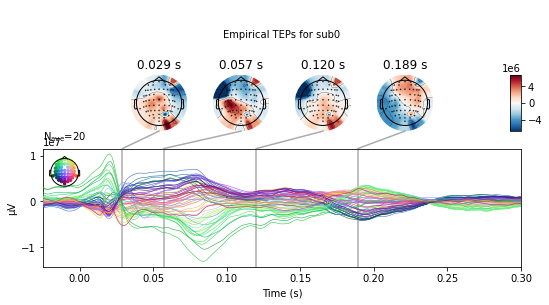

Projections have already been applied. Setting proj attribute to True.


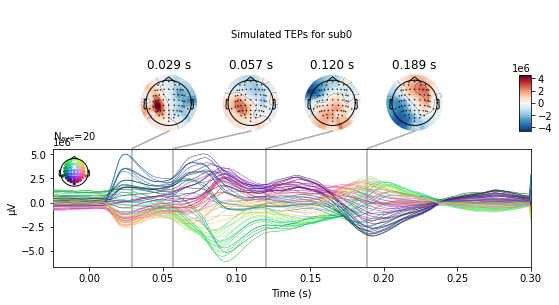

In [ ]:
# @title Plotting empirical data (top) and simulation
# Select Subject
sbj2plot = "0"  # @param [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

sbj2plot = int(sbj2plot)

epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()

empirical_data = epochs.average()
empirical_data.data = epochs._data[sbj2plot,:,:]

ts_args = dict(xlim=[-0.025,0.3])
ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.04)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.02, tmax=0.1)
#ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.12)
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.12, tmax=0.15)
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)
times = [peak_locs1, peak_locs2, peak_locs4, peak_locs5]

empirical_data.plot_joint(ts_args=ts_args, times=times, title='Empirical TEPs for sub' + str(sbj2plot) );

with open(pck_files[sbj2plot], 'rb') as f:
    data = pickle.load(f)

simulated_data = epochs.average()
simulated_data.data[:,900:1300]= data.output_sim.eeg_test

simulated_data.plot_joint(ts_args=ts_args, times=times, title='Simulated TEPs for sub' + str(sbj2plot) );


In [ ]:
from scipy import spatial 

only_high_trial = io.loadmat('/content/drive/MyDrive/TORONTO/EEG/only_high_trial.mat')['only_high_trial']
all_sim_EEG = []
all_sim_parcels = []


for sbj in range(only_high_trial.shape[0]):

  with open(pck_files[sbj], 'rb') as f:
      data = pickle.load(f)
  all_sim_EEG.append(data.output_sim.eeg_test)
  all_sim_parcels.append(data.output_sim.E_test - data.output_sim.I_test)

all_sim_EEG=np.array(all_sim_EEG)
all_sim_parcels=np.array(all_sim_parcels)

In [ ]:
from scipy.stats import norm
from scipy import stats
from random import shuffle
nPerms=1
pval    = 0.05 # p-value threshold
sigThresh =norm.ppf(1-pval) #note: two-tailed!


similarity = np.zeros((only_high_trial.shape[0],only_high_trial.shape[1]))
corr_r = np.zeros((only_high_trial.shape[0],only_high_trial.shape[1]))
corr_p = np.zeros((only_high_trial.shape[0],only_high_trial.shape[1]))

for subj in range(only_high_trial.shape[0]):
  evoked_T0 = only_high_trial[subj, :, 900:1300]
  evoked_T2 = all_sim_EEG[subj, :, :]
  for channel in range(evoked_T2.shape[0]):
    electrode_T0 = evoked_T0[channel,:]
    electrode_T2 = evoked_T2[channel,:]
    electrode_T0 = (electrode_T0-min(electrode_T0))/(max(electrode_T0)-min(electrode_T0))
    electrode_T2 = (electrode_T2-min(electrode_T2))/(max(electrode_T2)-min(electrode_T2))
    similarity[subj, channel] = 1 - spatial.distance.cosine(electrode_T0, electrode_T2)
    r, p = scipy.stats.pearsonr(electrode_T0, electrode_T2)
    corr_r[subj, channel] = r
    corr_p[subj, channel] = p



similarity_corr = similarity.copy()
similarity_corr = np.clip(similarity_corr,0,1,similarity_corr)
zthresh = np.abs(stats.zscore(similarity_corr)) 
zthresh[np.abs(zthresh) <sigThresh] = 0 #threshold z-score difference
zthresh_avg = np.mean(zthresh, axis=0)

corr_p_sign=corr_p.copy()
corr_p_sign_avg = np.mean(corr_p_sign, axis=0)
corr_p_sign_avg[corr_p_sign_avg > pval] = 0 #



fake_similarity = np.zeros((nPerms, only_high_trial.shape[0],only_high_trial.shape[1]))
fake_corr_p = np.zeros((nPerms, only_high_trial.shape[0],only_high_trial.shape[1]))
fake_corr_r = np.zeros((nPerms, only_high_trial.shape[0],only_high_trial.shape[1]))



for perm in range(nPerms): 
  for subj in range(only_high_trial.shape[0]):
    evoked_T0 = only_high_trial[subj, :, 900:1300]
    evoked_T2 = all_sim_EEG[subj, :, :]
    for channel in range(evoked_T2.shape[0]):
      electrode_T0 = evoked_T0[channel,:]
      ind_list = [i for i in range(electrode_T2.shape[0])]
      shuffle(ind_list)
      electrode_T0=electrode_T0[ind_list]

      electrode_T2 = evoked_T2[channel,:]
      ind_list = [i for i in range(electrode_T2.shape[0])]
      shuffle(ind_list)
      electrode_T2=electrode_T2[ind_list]

      electrode_T0 = (electrode_T0-min(electrode_T0))/(max(electrode_T0)-min(electrode_T0))
      electrode_T2 = (electrode_T2-min(electrode_T2))/(max(electrode_T2)-min(electrode_T2))
      fake_similarity[perm, subj, channel] = 1 - spatial.distance.cosine(electrode_T0, electrode_T2)
      r, p = scipy.stats.pearsonr(electrode_T0, electrode_T2)
      fake_corr_r[perm, subj, channel] = r
      fake_corr_p[perm, subj, channel] = p


fake_similarity_avg = np.mean(fake_similarity, axis=0)

fake_zthresh = np.abs(stats.zscore(fake_similarity_avg)) 
fake_zthresh[np.abs(fake_zthresh) <sigThresh] = 0 #threshold z-score difference
fake_zthresh_avg = np.mean(fake_zthresh, axis=0)

fake_corr_p_sign=fake_corr_p.copy()
fake_corr_p_avg = np.mean(np.mean(fake_corr_p_sign, axis=0), axis=0)
fake_corr_p_avg[fake_corr_p_avg > pval] = 0 #

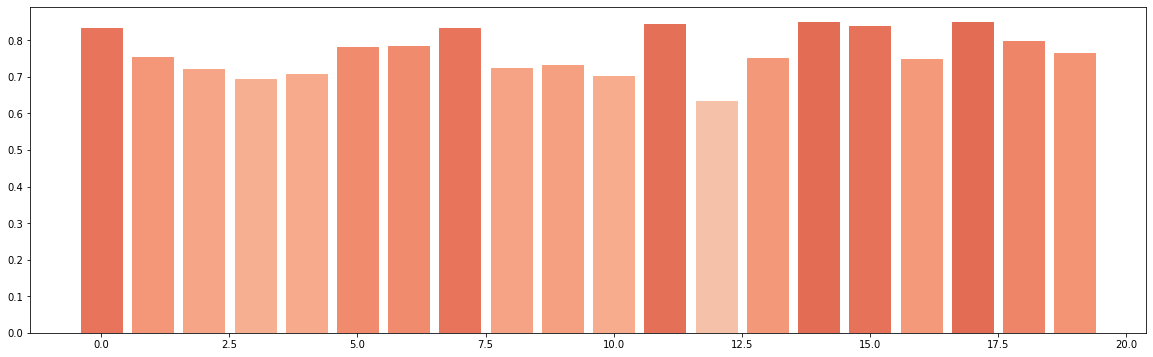

In [ ]:
x_pos = np.arange(corr_r.shape[0])
plt.rcParams["figure.figsize"] = (20,6)
barlist = plt.bar(x_pos, np.mean(corr_r, axis=1))


color_map=plt.get_cmap('coolwarm')

for xx in range(np.mean(corr_r, axis=1).shape[0]):
  rgba = color_map(np.mean(corr_r, axis=1)[xx])
  barlist[xx].set_color([rgba[0],rgba[1],rgba[2]])

In [ ]:
#
# Renzo Comolatti (renzo.com@gmail.com) and Adenauer G. Casali
#https://github.com/renzocom/PCIst/blob/master/PCIst/pci_st.py
# Please cite this paper if you use this code:
# Comolatti R et al., "A fast and general method to empirically estimate the complexity of brain responses
# to transcranial and intracranial stimulations" Brain Stimulation (2019)
# https://doi.org/10.1016/j.brs.2019.05.013
#
# started: 26/10/2017
# last update: 27/05/2019

import numpy as np
from numpy import linalg
import scipy.signal


def calc_PCIst(signal_evk, times, full_return=False, **par):
    ''' Calculates PCIst (Perturbational Complexity Index based on State transitions) of a signal.
    Parameters
    ----------
    signal_evk : ndarray
        2D array (ch, times) containing signal.
    times : ndarray
        1D array (time,) containing timepoints (negative values are baseline).
    full_return : bool
        Returns multiple variables involved in PCI computation.
    **pars : dictionary
        Dictionary containing parameters (see dimensionality_reduction(),
        state_transition_quantification()and preprocess_signal() documentation).
        Example:
        >> par = {'baseline_window':(-400,-50), 'response_window':(0,300), 'k':1.2, 'min_snr':1.1,
        'max_var':99, 'embed':False,'n_steps':100}
        >> PCIst, PCIst_bydim = calc_PCIst(signal_evoked, times, **par)

    Returns
    -------
    float
        PCIst value
    OR (if full_return==True)
    dict
        Dictionary containing all variables from calculation including array 'dNSTn' with PCIst decomposition.
    '''
    if np.any(np.isnan(signal_evk)):
        print('Data contains nan values.')
        return 0

    signal_evk, times = preprocess_signal(signal_evk, times, (par['baseline_window'][0],
                                                              par['response_window'][1]), **par)
    signal_svd, var_exp, eigenvalues, snrs = dimensionality_reduction(signal_evk, times, **par)
    STQ = state_transition_quantification(signal_svd, times, **par)

    PCI = np.sum(STQ['dNST'])

    if full_return:
        return {'PCI':PCI, **STQ, 'signal_evk':signal_evk, 'times':times, 'signal_svd':signal_svd,
                'eigenvalues':eigenvalues, 'var_exp':var_exp, 'snrs':snrs}
    return PCI

## DIMENSIONALITY REDUCTION
def dimensionality_reduction(signal, times, response_window, max_var=99, min_snr=1.1,
                             n_components=None, **kwargs):
    '''Returns principal components of signal according to SVD of the response.

    Calculates SVD at a given time interval (response_window) and uses the new basis to transform
    the whole signal yielding `n_components` principal components. The principal components are
    then selected to account for at least `max_var`% of the variance basesent in the signal's
    response.

    Parameters
    ----------
    signal : ndarray
        2D array (ch,time) containing signal.
    times : ndarray
        1D array (time,) containing timepoints
    response_window : tuple
        Signal's response time interval (ini,end).
    max_var: 0 < float <= 100
        Percentage of variance accounted for by the selected principal components.
    min_snr : float, optional
        Selects principal components with a signal-to-noise ratio (SNR) > min_snr.
    n_components : int, optional
        Number of principal components calculated (before selection).


    Returns
    -------
    np.ndarray
        2D array (ch,time) with selected principal components.
    np.ndarray
        1D array (n_components,) with `n_components` SVD eigenvalues of the signal's response.
    '''

    if not n_components:
        n_components = signal.shape[0]

    Vk, eigenvalues = get_svd(signal, times, response_window, n_components)
    var_exp = 100 * eigenvalues**2/np.sum(eigenvalues**2)

    signal_svd = apply_svd(signal, Vk)

    max_dim = calc_maxdim(eigenvalues, max_var)

    signal_svd = signal_svd[:max_dim, :]

    # if min_snr:
        # base_ini_ix = get_time_index(times, kwargs['baseline_window'][0])
        # base_end_ix = get_time_index(times, kwargs['baseline_window'][1])
        # resp_ini_ix = get_time_index(times, response_window[0])
        # resp_end_ix = get_time_index(times, response_window[1])
        # n_dims = np.size(signal_svd, 0)
        # snrs = np.zeros(n_dims)
        # for c in range(n_dims):
        #     resp_power = np.mean(np.square(signal_svd[c, resp_ini_ix:resp_end_ix]))
        #     base_power = np.mean(np.square(signal_svd[c, base_ini_ix:base_end_ix]))
        #     snrs[c] = np.sqrt(np.divide(resp_power, base_power))
    snrs = calc_snr(signal_svd, times, kwargs['baseline_window'], response_window)
    signal_svd = signal_svd[snrs > min_snr, :]
    snrs = snrs[snrs > min_snr]

    Nc = signal_svd.shape[0]

    return signal_svd, var_exp[:Nc], eigenvalues, snrs

def calc_snr(signal_svd, times, baseline_window, response_window):

    base_ini_ix = get_time_index(times, baseline_window[0])
    base_end_ix = get_time_index(times, baseline_window[1])
    resp_ini_ix = get_time_index(times, response_window[0])
    resp_end_ix = get_time_index(times, response_window[1])

    resp_power = np.mean(np.square(signal_svd[:,resp_ini_ix:resp_end_ix]), axis=1)
    base_power = np.mean(np.square(signal_svd[:,base_ini_ix:base_end_ix]), axis=1)
    snrs = np.sqrt(resp_power / base_power)
    return snrs

def get_svd(signal_evk, times, response_window, n_components):
    ini_t, end_t = response_window
    ini_ix = get_time_index(times, onset=ini_t)
    end_ix = get_time_index(times, onset=end_t)
    signal_resp = signal_evk[:, ini_ix:end_ix].T
    U, S, V = linalg.svd(signal_resp, full_matrices=False)
    V = V.T
    Vk = V[:, :n_components]
    eigenvalues = S[:n_components]
    return Vk, eigenvalues

def apply_svd(signal, V):
    '''Transforms signal according to SVD basis.'''
    return signal.T.dot(V).T

## STATE TRANSITION QUANTIFICATION
def state_transition_quantification(signal, times, k, baseline_window, response_window, embed=False,
                                    L=None, tau=None, n_steps=100, max_thr_p=1.0, **kwargs):
    ''' Receives selected principal components of perturbational signal and
    performs state transition quantification.

    Parameters
    ----------
    signal : ndarray
        2D array (component,time) containing signal (typically, the selected
        principal components).
    times : ndarray
        1D array (time,) containing timepoints
    k : float > 1
        Noise control parameter.
    baseline_window : tuple
        Signal's baseline time interval (ini,end).
    response_window : tuple
        Signal's response time interval (ini,end).
    embed : bool, optional
        Perform time-delay embedding.
    L : int
        Number of embedding dimensions.
    tau : int
        Number of timesamples of embedding delay
    n_steps : int, optional
        Number of steps used to search for the threshold that maximizes ∆NST.
        Search is performed by partitioning  the interval (defined from the median
        of the baseline’s distance matrix to the maximum of the response’s
        distance matrix) into ‘n_steps’ equal lengths.

    Returns
    -------
    float
        PCIst value.
    ndarray
        List containing component wise PCIst value (∆NSTn).
    '''

    n_dims = signal.shape[0]
    if n_dims == 0:
        print('No components --> PCIst=0')
        return {'dNST':np.array([]), 'n_dims':0}

    # EMBEDDING
    if embed:
        cut = (L-1)*tau
        times = times[cut:]
        temp_signal = np.zeros((n_dims, L, len(times)))
        for i in range(n_dims):
            temp_signal[i, :, :] = dimension_embedding(signal[i, :], L, tau)
        signal = temp_signal

    else:
        signal = signal[:, np.newaxis, :]

    # BASELINE AND RESPONSE DEFINITION
    base_ini_ix = get_time_index(times, baseline_window[0])
    base_end_ix = get_time_index(times, baseline_window[1])
    resp_ini_ix = get_time_index(times, response_window[0])
    resp_end_ix = get_time_index(times, response_window[1])
    n_baseline = len(times[base_ini_ix:base_end_ix])
    n_response = len(times[resp_ini_ix:resp_end_ix])

    if n_response <= 1 or n_baseline <= 1:
        print('Warning: Bad time interval defined.')

    baseline = signal[:, :, base_ini_ix:base_end_ix]
    response = signal[:, :, resp_ini_ix:resp_end_ix]

    # NST CALCULATION
        # Distance matrix
    D_base = np.zeros((n_dims, n_baseline, n_baseline))
    D_resp = np.zeros((n_dims, n_response, n_response))
        # Transition matrix
    T_base = np.zeros((n_steps, n_dims, n_baseline, n_baseline))
    T_resp = np.zeros((n_steps, n_dims, n_response, n_response))
        # Number of state transitions
    NST_base = np.zeros((n_steps, n_dims))
    NST_resp = np.zeros((n_steps, n_dims))
    thresholds = np.zeros((n_steps, n_dims))
    for i in range(n_dims):
        D_base[i, :, :] = recurrence_matrix(baseline[i, :, :], thr=None, mode='distance')
        D_resp[i, :, :] = recurrence_matrix(response[i, :, :], thr=None, mode='distance')
        min_thr = np.median(D_base[i, :, :].flatten())
        max_thr = np.max(D_resp[i, :, :].flatten()) * max_thr_p
        thresholds[:, i] = np.linspace(min_thr, max_thr, n_steps)
    for i in range(n_steps):
        for j in range(n_dims):
            T_base[i, j, :, :] = distance2transition(D_base[j, :, :], thresholds[i, j])
            T_resp[i, j, :, :] = distance2transition(D_resp[j, :, :], thresholds[i, j])

            NST_base[i, j] = np.sum(T_base[i, j, :, :])/n_baseline**2
            NST_resp[i, j] = np.sum(T_resp[i, j, :, :])/n_response**2

    # PCIST
    NST_diff = NST_resp - k * NST_base
    ixs = np.argmax(NST_diff, axis=0)
    max_thresholds = np.array([thresholds[ix, i] for ix, i in zip(ixs, range(n_dims))])
    dNST = np.array([NST_diff[ix, i] for ix, i in zip(ixs, range(n_dims))]) * n_response
    dNST = [x if x>0 else 0 for x in dNST]

    temp = np.zeros((n_dims, n_response, n_response))
    temp2 = np.zeros((n_dims, n_baseline, n_baseline))
    for i in range(n_dims):
        temp[i, :, :] = T_resp[ixs[i], i, :, :]
        temp2[i, :, :] = T_base[ixs[i], i, :, :]
    T_resp = temp
    T_base = temp2

    return {'dNST':dNST, 'n_dims':n_dims,
    'D_base':D_base, 'D_resp':D_resp, 'T_base':T_base,'T_resp':T_resp,
    'thresholds':thresholds, 'NST_diff':NST_diff, 'NST_resp':NST_resp, 'NST_base':NST_base,'max_thresholds':max_thresholds}


def recurrence_matrix(signal, mode, thr=None):
    ''' Calculates distance, recurrence or transition matrix. Signal can be
    embedded (m, n_times) or not (, n_times).

    Parameters
    ----------
    signal : ndarray
        Time-series; may be a 1D (time,) or a m-dimensional array (m, time) for
        time-delay embeddeding.
    mode : str
        Specifies calculated matrix: 'distance', 'recurrence' or 'transition'
    thr : float, optional
        If transition matrix is chosen (`mode`=='transition'), specifies threshold value.

    Returns
    -------
    ndarray
        2D array containing specified matrix.
    '''
    if len(signal.shape) == 1:
        signal = signal[np.newaxis, :]
    n_dims = signal.shape[0]
    n_times = signal.shape[1]

    R = np.zeros((n_dims, n_times, n_times))
    for i in range(n_dims):
        D = np.tile(signal[i, :], (n_times, 1))
        D = D - D.T
        R[i, :, :] = D
    R = np.linalg.norm(R, ord=2, axis=0)

    mask = (R <= thr) if thr else np.zeros(R.shape).astype(bool)
    if mode == 'distance':
        R[mask] = 0
        return R
    if mode == 'recurrence':
        return mask.astype(int)
    if mode == 'transition':
        return diff_matrix(mask.astype(int), symmetric=False)
    return 0

def distance2transition(dist_R, thr):
    ''' Receives 2D distance matrix and calculates transition matrix. '''
    mask = dist_R <= thr
    R = diff_matrix(mask.astype(int), symmetric=False)
    return R

def distance2recurrence(dist_R, thr):
    ''' Receives 2D distance matrix and calculates recurrence matrix. '''
    mask = dist_R <= thr
    return mask.astype(int)

def diff_matrix(A, symmetric=False):
    B = np.abs(np.diff(A))
    if B.shape[1] != B.shape[0]:
        B2 = np.zeros((B.shape[0], B.shape[1]+1))
        B2[:, :-1] = B
        B = B2
    if symmetric:
        B = (B + B.T)
        B[B > 0] = 1
    return B

def calc_maxdim(eigenvalues, max_var):
    ''' Get number of dimensions that accumulates at least `max_var`% of total variance'''
    if max_var == 100:
        return len(eigenvalues)
    eigenvalues = np.sort(eigenvalues)[::-1] # Sort in descending order
    var = eigenvalues ** 2
    var_p = 100 * var/np.sum(var)
    var_cum = np.cumsum(var_p)
    max_dim = len(eigenvalues) - np.sum(var_cum >= max_var) + 1
    return max_dim

def dimension_embedding(x, L, tau):
    '''
    Returns time-delay embedding of vector.
    Parameters
    ----------
    x : ndarray
        1D array time series.
    L : int
        Number of dimensions in the embedding.
    tau : int
        Number of samples in delay.
    Returns
    -------
    ndarray
        2D array containing embedded signal (L, time)

    '''
    assert len(x.shape) == 1, "x must be one-dimensional array (n_times,)"
    n_times = x.shape[0]
    s = np.zeros((L, n_times - (L-1) * tau))
    ini = (L-1) * tau if L > 1 else None
    s[0, :] = x[ini:]
    for i in range(1, L):
        ini = (L-i-1) * tau
        end = -i * tau
        s[i, :] = x[ini:end]
    return s

## PREPROCESS
def preprocess_signal(signal_evk, times, time_window, baseline_corr=False, resample=None,
                      avgref=False, **kwargs):
    assert signal_evk.shape[1] == len(times), 'Signal and Time arrays must be of the same size.'
    if avgref:
        signal_evk = avgreference(signal_evk)
    if baseline_corr:
        signal_evk = baseline_correct(signal_evk, times, delta=-50)
    t_ini, t_end = time_window
    ini_ix = get_time_index(times, t_ini)
    end_ix = get_time_index(times, t_end)
    signal_evk = signal_evk[:, ini_ix:end_ix]
    times = times[ini_ix:end_ix]
    if resample:
        signal_evk, times = undersample_signal(signal_evk, times, new_fs=resample)
    return signal_evk, times

def avgreference(signal):
    ''' Performs average reference to signal. '''
    new_signal = np.zeros(signal.shape)
    channels_mean = np.mean(signal, axis=0)[np.newaxis]
    new_signal = signal - channels_mean
    return new_signal

def undersample_signal(signal, times, new_fs):
    '''
    signal : (ch x times)
    times : (times,) [ms]
    new_fs : [hz]
    '''
    n_samples = int((times[-1]-times[0])/1000 * new_fs)
    new_signal_evk, new_times = scipy.signal.resample(signal, n_samples, t=times, axis=1)
    return new_signal_evk, new_times

def baseline_correct(Y, times, delta=0):
    ''' Baseline correct signal using times < delta '''
    newY = np.zeros(Y.shape)
    onset_ix = get_time_index(times, delta)
    baseline_mean = np.mean(Y[:, :onset_ix], axis=1)[np.newaxis]
    newY = Y - baseline_mean.T
    close_enough = np.all(np.isclose(np.mean(newY[:, :onset_ix], axis=1), 0, atol=1e-08))
    assert close_enough, "Baseline mean is not zero"
    return newY

def get_time_index(times, onset=0):
    ''' Returns index of first time greater then delta. For delta=0 gets index of
    first non-negative time.
    '''
    return np.sum(times < onset)

# @title Creating function for calculating PCI

In [ ]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

#@title function for plotting multiple bar

In [ ]:
epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()

par = {'baseline_window':(-0.4,-0.1), 'response_window':(0,0.3), 'k':1.2, 'min_snr':1.1,
        'max_var':99, 'embed':False,'n_steps':100}

PCI_sim = np.zeros((epochs._data.shape[0]))
PCI_emp = np.zeros((epochs._data.shape[0]))

for sbj in range(epochs._data.shape[0]):
  PCI_emp[sbj] = calc_PCIst(epochs._data[sbj, :, :], evoked.times, **par, full_return=False) 
  with open(pck_files[sbj], 'rb') as f:
    data = pickle.load(f)
    simulated_EEG_st=evoked.copy()
    simulated_EEG_st.data[:,900:1300] = data.output_sim.eeg_test
    PCI_sim[sbj] = calc_PCIst(simulated_EEG_st._data, evoked.times, **par, full_return=False) 

<ipython-input-19-dc10bd8e4303>:1: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


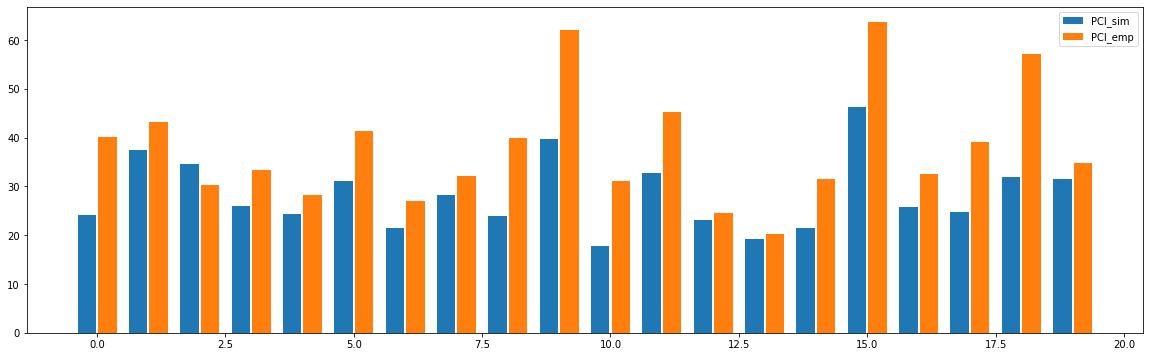

In [ ]:
data2plot = {
          "PCI_sim": PCI_sim,
          "PCI_emp": PCI_emp,
}

plt.rcParams["figure.figsize"] = (20,6)
fig, ax = plt.subplots()
bar_plot(ax, data2plot, total_width=.8, single_width=.9)
plt.show()

Text(0.5, 1.0, 'R2=0.79 p=0.0')

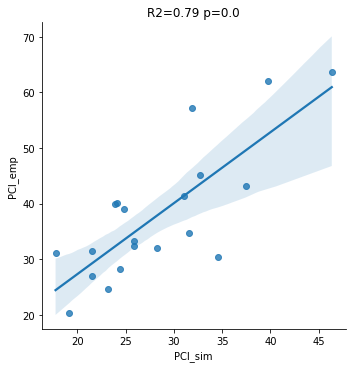

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
df2plot = pd.DataFrame(np.vstack((PCI_sim, PCI_emp)).T, columns = ['PCI_sim', 'PCI_emp'])

scatter = sns.lmplot(x="PCI_sim", y="PCI_emp", data=df2plot);
r, p = scipy.stats.pearsonr(df2plot['PCI_sim'], df2plot['PCI_emp'])
ax = plt.gca()
ax.set_title('R2=' + str(round(r,2)) + ' p=' + str(round(p,2)))


In [ ]:
# @title Spider and bar plot
from math import pi

def spider_plot(excel_labels, values2plot, colour=None, linestyle=None, linecolour=None,
                linewidth=None, label_colour=None, label_size=None, alpha=None,
                ylim=None):

    '''
    spider plot of network measures in percentage
    Parameters
    ----------
    excel_labels: excel file |
        please se example available in the repo (e.g. network_colour.xlsx)
    values2plot: np.array |
        values to plot must have the same dimension of excel_labels
    colour (optional) = scalar or array-like, optional
        set the colors of the plot (Default is 'orange')
    linestyle (optional) :  str |
        set the patch linestyle (e.g. '-' or 'solid', '--' or 'dashed', '-.'
        or 'dashdot', ':' or 'dotted') (Default is 'solid')
    linecolour (optional): float |
        set the colors of the line (Default is 'orange')
    linewidth (optional): scalar or array-like, optional
        Width of the bar edge(s). If 0, don't draw edges. (Default is 1)
    label_colour: scalar or array-like, optional
        set the colors of the labels (Default is 'black')
    label_size (optional): scalar |
        set the size of labels (Default is 8)
    alpha (optional): float |
        set the alpha transparency of the patch (Default is 0.5)
    ylim (optional): scalar |
        (by default it will automatically adjust the ylim)
    '''

    if alpha==None:
        alpha = 0.5
    else:
        alpha= alpha

    if label_colour==None:
        label_colour='black'
    else:
        label_colour=label_colour

    if label_size==None:
        label_size=8
    else:
        label_size=label_size

    if linewidth==None:
        linewidth=1
    else:
        linewidth=linewidth

    if linecolour==None:
        linecolour='orange'
    else:
        linecolour=linecolour

    if linestyle==None:
        linestyle='solid'
    else:
        linestyle=linestyle

    if colour==None:
        colour= 'orange'
    else:
        colour=colour

    labels = list(np.array(pd.read_excel(excel_labels, header=None))[:,0])
    values = values2plot * 100 / np.sum(values2plot)

    if ylim==None:
        ylim= np.max(values) + (10 - np.max(values)  % 10)
    else:
        ylim=ylim

    values = values.tolist()
    values += values[:1]
    N = len(labels)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    ax = plt.subplot(111, polar=True)

    plt.xticks(angles, labels, color=label_colour, size=label_size)

    ax.set_rlabel_position(0)
    plt.ylim(0,ylim)

    ax.plot(angles, values, linecolour , linewidth=linewidth, linestyle=linestyle)

    ax.fill(angles, values, colour, alpha=alpha)
    plt.show()


def bar_plot(excel_labels, data, out=None, xerr=False, align=None, alpha=None,
            xlabel=None, xlim=None, percentage_value=False):

    '''
    bar plot of network measures
    Parameters
    ----------
    excel_labels: excel file |
        please se example available in the repo (e.g. network_colour.xlsx)
    values2plot = np.array |
        values to plot must have the same dimension of excel_labels
    align (optional) = str |
        Alignment of the bars to the x coordinates (e.g.'center' will center
        the base on the x positions; 'edge' will align the left edges of the
        bars with the x positions. To align the bars on the right edge pass
        a negative width and align='edge') (Default is 'center')
    alpha (optional) = float |
        set the alpha transparency of the patch (Default is 0.8)
    xlabel (optional) = str |
        set the label of x axis (Default is 'Connectivity')
    percentage_value (optional) : Boolean|
        True return values express in percentage_value
        False return raw values (Default is False)
    '''
    values2plot = np.mean(data, axis=0)

    if align==None:
        align='center'
    else:
        align=align

    if alpha==None:
        alpha=0.8
    else:
        alpha=alpha

    if xlabel==None:
        xlabel='Connectivity'
    else:
        xlabel=xlabel

    if xerr==False:
        SEM = None
    elif xerr=='std':
        if percentage_value==False:
            SEM = np.std(data, axis=0)
        else:
            SEM = 100* np.std(data, axis=0)/np.sum(values2plot)
    elif xerr=='sem':
        if percentage_value==False:
            SEM = sem(data)
        else:
            SEM = 100* sem(data) / np.sum(values2plot)

    if percentage_value==False:
        values = values2plot
    else:
        values = 100* values2plot/np.sum(values2plot)




    network2use = pd.read_excel(excel_labels, header=None)
    Net_label=list(network2use[0])
    barlist= plt.barh(np.arange(len(Net_label)), values, xerr=SEM, align=align, alpha=alpha)
    plt.yticks(np.arange(len(Net_label)), Net_label)
    plt.xlabel(xlabel)

    if xlim==None:
      plt.xlim(np.min(values) - np.std(values), np.max(values) + np.std(values))
    else:
       plt.xlim(xlim)

    for net in range(len(Net_label)):
        barlist[net].set_color([network2use[1][net]/255.0,network2use[2][net]/255.0,network2use[3][net]/255.0])

    if out==None:
      pass
    else:
      plt.savefig(out)
    plt.show()

Projections have already been applied. Setting proj attribute to True.


<ipython-input-79-976a54335031>:1: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)


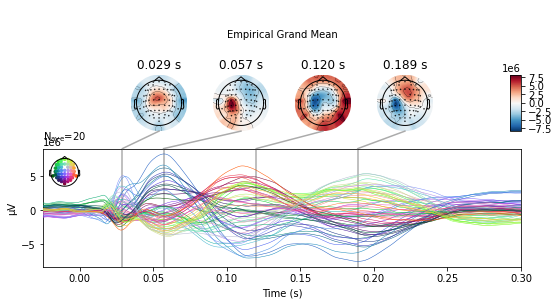

Projections have already been applied. Setting proj attribute to True.


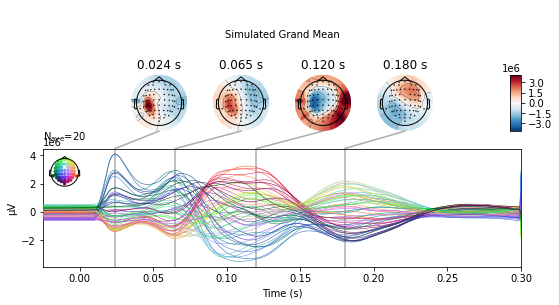

In [ ]:
epochs = mne.read_epochs('/content/drive/MyDrive/TORONTO/EEG/all_avg.mat_avg_high_epoched', verbose=False)
evoked = epochs.average()


ts_args = dict(xlim=[-0.025,0.3])
ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.04)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.04, tmax=0.07)
#ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.12)
ch, peak_locs4 = evoked.get_peak(ch_type='eeg', tmin=0.12, tmax=0.15)
ch, peak_locs5 = evoked.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)
times = [peak_locs1, peak_locs2, peak_locs4, peak_locs5]

evoked.plot_joint(ts_args=ts_args, times=times, title='Empirical Grand Mean');


epochs._data[:,:,900:1300] = all_sim_EEG

sim_evoked = epochs.average()


ts_args = dict(xlim=[-0.025,0.3])
ch, peak_locs1 = sim_evoked.get_peak(ch_type='eeg', tmin=-0.05, tmax=0.04)
ch, peak_locs2 = sim_evoked.get_peak(ch_type='eeg', tmin=0.04, tmax=0.07)
#ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.1, tmax=0.12)
ch, peak_locs4 = sim_evoked.get_peak(ch_type='eeg', tmin=0.12, tmax=0.15)
ch, peak_locs5 = sim_evoked.get_peak(ch_type='eeg', tmin=0.15, tmax=0.20)
times = [peak_locs1, peak_locs2, peak_locs4, peak_locs5]

sim_evoked.plot_joint(ts_args=ts_args, times=times, title='Simulated Grand Mean');

<ipython-input-67-d3e97c33ba0f>:14: RuntimeWarning: This filename (/content/drive/MyDrive/TORONTO/EEG/fsaverage/fsaverage-src) does not conform to MNE naming conventions. All source space files should end with -src.fif, -src.fif.gz, _src.fif, _src.fif.gz, -fwd.fif, -fwd.fif.gz, _fwd.fif, _fwd.fif.gz, -inv.fif, -inv.fif.gz, _inv.fif or _inv.fif.gz
  src = mne.read_source_spaces('/content/drive/MyDrive/TORONTO/EEG/fsaverage/fsaverage-src', verbose=False)


Extracting time courses for 202 labels (mode: mean_flip)
Extracting time courses for 202 labels (mode: mean_flip)


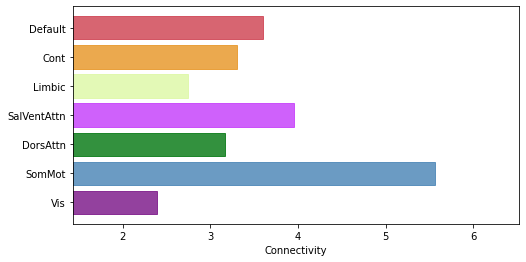

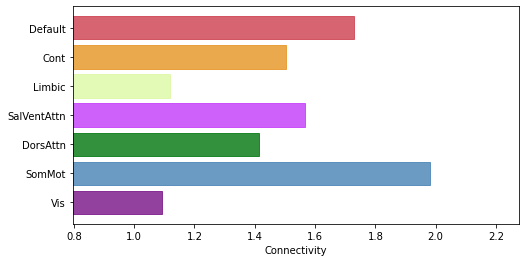

In [ ]:
os.chdir('/content/drive/MyDrive/TORONTO/EEG/')

sim_stc = mne.read_source_estimate('/content/drive/MyDrive/TORONTO/EEG/stc_sim_evoked_new')
real_stc = mne.read_source_estimate('/content/drive/MyDrive/TORONTO/EEG/all_avg_high-stc')



parcels_path=  '/Volumes/WD_Elements/ATLASES/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/'
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
label = pd.read_csv(url)
label = label['ROI Name']
label_stripped = []

src = mne.read_source_spaces('/content/drive/MyDrive/TORONTO/EEG/fsaverage/fsaverage-src', verbose=False)

labels_Schaefer = mne.read_labels_from_annot('fsaverage', parc='Schaefer2018_200Parcels_7Networks_order', subjects_dir='/content/drive/MyDrive/TORONTO/EEG/', verbose=False)

labels_Schaefer_names = []

for xx in range(1,len(labels_Schaefer)-1):
  labels_Schaefer_names.append(labels_Schaefer[xx].name[10:])

real_label_ts = mne.extract_label_time_course(real_stc, labels_Schaefer, src, mode='mean_flip')

sim_label_ts = mne.extract_label_time_course(sim_stc, labels_Schaefer, src, mode='mean_flip')

start = np.where(epochs.times==0.03)[0][0]
end = np.where(epochs.times==0.3)[0][0]

Vis_real = np.mean(np.mean(real_label_ts[Vis_idx, start:end], axis=0))
SomMot_real = np.mean(np.mean(real_label_ts[SomMot_idx, start:end], axis=0))
DorsAttn_real = np.mean(np.mean(real_label_ts[DorsAttn_idx, start:end], axis=0))
SalVentAttn_real = np.mean(np.mean(real_label_ts[SalVentAttn_idx, start:end], axis=0))
Limbic_real = np.mean(np.mean(real_label_ts[Limbic_idx, start:end], axis=0))
Cont_real = np.mean(np.mean(real_label_ts[Cont_idx, start:end], axis=0))
Default_real = np.mean(np.mean(real_label_ts[Default_idx, start:end], axis=0))
Network_real = np.vstack((Vis_real, SomMot_real, DorsAttn_real, SalVentAttn_real, Limbic_real, Cont_real, Default_real)).T


plt.rcParams["figure.figsize"] = (8,4)
bar_plot('/content/drive/MyDrive/HCP_project/data_matrix/network_colour.xlsx', Network_real)




Vis_sim = np.mean(np.mean(sim_label_ts[Vis_idx, start:end], axis=0))
SomMot_sim = np.mean(np.mean(sim_label_ts[SomMot_idx, start:end], axis=0))
DorsAttn_sim = np.mean(np.mean(sim_label_ts[DorsAttn_idx, start:end], axis=0))
SalVentAttn_sim = np.mean(np.mean(sim_label_ts[SalVentAttn_idx, start:end], axis=0))
Limbic_sim = np.mean(np.mean(sim_label_ts[Limbic_idx, start:end], axis=0))
Cont_sim = np.mean(np.mean(sim_label_ts[Cont_idx, start:end], axis=0))
Default_sim = np.mean(np.mean(sim_label_ts[Default_idx, start:end], axis=0))
Network_sim = np.vstack((Vis_sim, SomMot_sim, DorsAttn_sim, SalVentAttn_sim, Limbic_sim, Cont_sim, Default_sim)).T


plt.rcParams["figure.figsize"] = (8,4)
bar_plot('/content/drive/MyDrive/HCP_project/data_matrix/network_colour.xlsx', Network_sim)


In [ ]:
import gdown

url = 'https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF'
destination = '/content/drive/MyDrive/TORONTO/EEG/reproduce_fig/data.tgz'
gdown.download(url, destination, quiet=False)

/usr/local/lib/python3.7/dist-packages/gdown/parse_url.py:39: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  url="https://drive.google.com/uc?id={}".format(file_id)
Downloading...
From: https://drive.google.com/drive/folders/1iwsxrmu_rnDCvKNYDwTskkCNt709MPuF
To: /content/drive/MyDrive/TORONTO/EEG/reproduce_fig/data.tgz
859kB [00:00, 33.0MB/s]


'/content/drive/MyDrive/TORONTO/EEG/reproduce_fig/data.tgz'